# The behaviours of (logit)binarycrossentopy
https://github.com/FluxML/Flux.jl/issues/914

In [231]:
using Flux
using Plots
using Roots
using Measures

## Implementation
In Flux.jl, the definitions of binarycrossentropy and logitbinarycrossentopy are
\begin{align}
\text{binarycrossentropy}(\hat{y}, y) & = -y\log(\hat{y} + \epsilon)-(1-y)\log(1-\hat{y} + \epsilon), \epsilon = \text{eps}(\hat{y})\\
\text{logitbinarycrossentropy}(\log\hat{y}, y) & = (1-y)\log \hat{y} - \log\sigma (\log\hat{y})
\end{align}
https://github.com/FluxML/Flux.jl/blob/master/src/layers/stateless.jl#L37  
https://github.com/FluxML/Flux.jl/blob/master/src/layers/stateless.jl#L54

For $x \in \text{Float32},$ sigmoid function is defined as 
\begin{align}
\sigma(x) & = 
    \begin{cases}
        0, & x < -80 \\
        \frac{1}{1 + e^{-x}}, & \text{otherwise}
    \end{cases}
\end{align}
https://github.com/FluxML/NNlib.jl/blob/master/src/activation.jl#L15

In [185]:
xs_float32 = collect(Float32, 0:50);
xs_float64 = collect(Float64, 0:50);

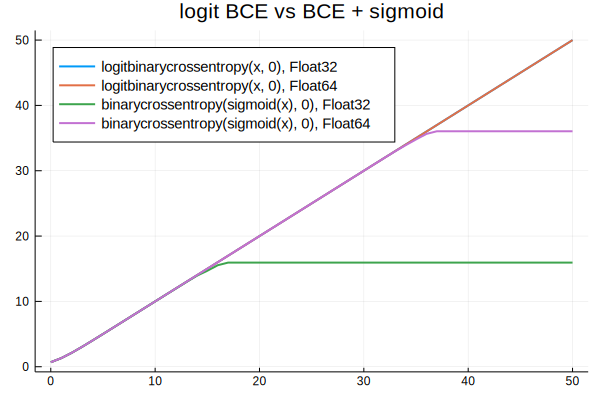

In [192]:
plot(legend = :topleft, legendfontsize = 10, title = "logit BCE vs BCE + sigmoid")
plot!(xs_float32, Flux.logitbinarycrossentropy.(xs_float32, 0), 
    label = "logitbinarycrossentropy(x, 0), Float32", lw = 2)
plot!(xs_float64, Flux.logitbinarycrossentropy.(xs_float64, 0), 
    label = "logitbinarycrossentropy(x, 0), Float64", lw = 2)
plot!(xs_float32, Flux.binarycrossentropy.(sigmoid.(xs_float32), 0), 
    label = "binarycrossentropy(sigmoid(x), 0), Float32", lw = 2)
plot!(xs_float64, Flux.binarycrossentropy.(sigmoid.(xs_float64), 0), 
    label = "binarycrossentropy(sigmoid(x), 0), Float64", lw = 2)

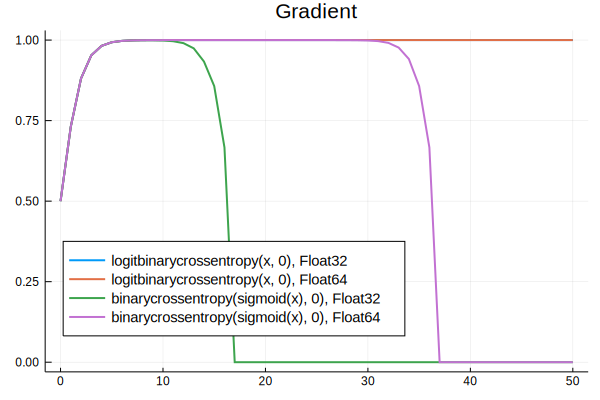

In [195]:
plot(legend = :bottomleft, legendfontsize = 10, title = "Gradient")
ys = getindex.(gradient.(x->Flux.logitbinarycrossentropy(x, 0), xs_float32), 1)
plot!(xs_float32, ys, label = "logitbinarycrossentropy(x, 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.logitbinarycrossentropy(x, 0), xs_float64), 1)
plot!(xs_float64, ys, label = "logitbinarycrossentropy(x, 0), Float64", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(sigmoid.(x), 0), xs_float32), 1)
plot!(xs_float32, ys, label = "binarycrossentropy(sigmoid(x), 0), Float32", lw = 2)
ys = getindex.(gradient.(x->Flux.binarycrossentropy.(sigmoid.(x), 0), xs_float64), 1)
plot!(xs_float64, ys, label = "binarycrossentropy(sigmoid(x), 0), Float64", lw = 2)

## What's happened?

In [239]:
f_float32(x) = 1f0 + exp(-x) - 1f0

f_float32 (generic function with 1 method)

In [279]:
x_l, x_r = 16f0, 17f0
while true
    x_mid = (x_l + x_r) * 0.5f0
    if f_float32(x_mid) > 0f0
        x_l = x_mid
    else
        x_r = x_mid
    end
    
    println(x_l, ",", x_r)
    if nextfloat(x_l) == x_r
        break
    end
end

16.5,17.0
16.5,16.75
16.625,16.75
16.625,16.6875
16.625,16.65625
16.625,16.640625
16.632812,16.640625
16.632812,16.636719
16.634766,16.636719
16.634766,16.635742
16.635254,16.635742
16.635498,16.635742
16.635498,16.63562
16.635498,16.63556
16.635529,16.63556
16.635529,16.635544
16.635529,16.635536
16.635529,16.635532
16.63553,16.635532


In [283]:
x_l, x_r

(16.63553f0, 16.635532f0, 16.635532f0)

In [284]:
f_float32(x_l), f_float32(x_r)

(1.1920929f-7, 0.0f0)

In [253]:
f_float32(16f0)

1.1920929f-7

In [181]:
1 .+ exp.(-(30:50))

21-element Array{Float64,1}:
 1.0000000000000935
 1.0000000000000344
 1.0000000000000127
 1.0000000000000047
 1.0000000000000018
 1.0000000000000007
 1.0000000000000002
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               
 1.0               

In [156]:
f1(x) = 1f0 - x + eps(x)

f1 (generic function with 1 method)

In [157]:
l = 20
xs = Float32[]
t = 1f0
for i in 1:l
    push!(xs, t)
    t = prevfloat(t)
end
reverse!(xs)

20-element Array{Float32,1}:
 0.99999887
 0.9999989 
 0.999999  
 0.99999905
 0.9999991 
 0.99999917
 0.9999992 
 0.9999993 
 0.99999934
 0.9999994 
 0.99999946
 0.9999995 
 0.9999996 
 0.99999964
 0.9999997 
 0.99999976
 0.9999998 
 0.9999999 
 0.99999994
 1.0       

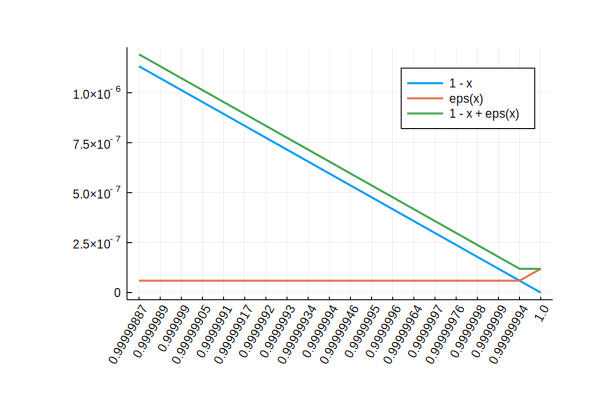

In [165]:
plot(1:l, 1f0 .- xs, xticks = (1:l, xs), label = "1 - x", lw = 2, xrotation = 60, margin = 10mm)
plot!(1:l, eps.(xs), xticks = (1:l, xs), label = "eps(x)", lw = 2)
plot!(1:l, f1.(xs), xticks = (1:l, xs), label = "1 - x + eps(x)", lw = 2)